# Machine Learning Algorithms

In [40]:
import time
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

In [41]:
data = shuffled_data

X = data.iloc[:, :-1] 
y = data.iloc[:, -1]  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialization 

In [42]:
# Initialize Classifiers
classifiers = {
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(tree_method='gpu_hist'), 
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Extra Trees': ExtraTreesClassifier()
}

In [43]:
# Initialize Evaluation Metrics
evaluation_metrics = {name: {'Accuracy': None, 'Precision': None, 'Recall': None, 'F1-score': None, 'AUC-ROC': None} for name in classifiers}
training_times = {}
confusion_matrices = {}
classification_reports = {}

In [44]:
def safe_metric_calculation(metric_function, true_values, predictions, **kwargs):
    try:
        return metric_function(true_values, predictions, **kwargs)
    except ValueError as e:
        print(f"Error calculating metric: {e}")
        return None

# Machine Learning Evaluation 

In [45]:
# Iterate over classifiers
for name, classifier in classifiers.items():
    start_time = time.time()
    classifier.fit(X_train, y_train) 
    end_time = time.time()

    y_pred = classifier.predict(X_test) 

    # Calculate and store evaluation metrics
    evaluation_metrics[name]['Accuracy'] = safe_metric_calculation(accuracy_score, y_test, y_pred)
    evaluation_metrics[name]['Precision'] = safe_metric_calculation(precision_score, y_test, y_pred, zero_division=0)
    evaluation_metrics[name]['Recall'] = safe_metric_calculation(recall_score, y_test, y_pred)
    evaluation_metrics[name]['F1-score'] = safe_metric_calculation(f1_score, y_test, y_pred)
    evaluation_metrics[name]['AUC-ROC'] = safe_metric_calculation(roc_auc_score, y_test, y_pred)

    confusion_matrices[name] = confusion_matrix(y_test, y_pred)
    classification_reports[name] = classification_report(y_test, y_pred) 
    training_times[name] = end_time - start_time 

# Display results
results_df = pd.DataFrame(evaluation_metrics).T
print("Evaluation Metrics:\n", results_df)

print("\nConfusion Matrices:")
for name, matrix in confusion_matrices.items():
    print(f"\n{name}:")
    print(matrix)

print("\nClassification Reports:")
for name, report in classification_reports.items():
    print(f"\n{name}:")
    print(report)

print("\nTraining Times:")
for name, time_taken in training_times.items():
    print(f"{name}: {time_taken:.2f} seconds")

Evaluation Metrics:
                Accuracy  Precision    Recall  F1-score   AUC-ROC
KNN            0.699440   0.714897  0.663076  0.688012  0.699425
Random Forest  0.704939   0.724407  0.661182  0.691352  0.704922
XGBoost        0.694629   0.716838  0.643015  0.677923  0.694609
Decision Tree  0.607463   0.607236  0.607635  0.607436  0.607464

Confusion Matrices:

KNN:
[[57152 20524]
 [26150 51464]]

Random Forest:
[[58153 19523]
 [26297 51317]]

XGBoost:
[[57962 19714]
 [27707 49907]]

Decision Tree:
[[47172 30504]
 [30453 47161]]

Classification Reports:

KNN:
              precision    recall  f1-score   support

           0       0.69      0.74      0.71     77676
           1       0.71      0.66      0.69     77614

    accuracy                           0.70    155290
   macro avg       0.70      0.70      0.70    155290
weighted avg       0.70      0.70      0.70    155290


Random Forest:
              precision    recall  f1-score   support

           0       0.69      0.7

# Visualization Confusion Matrices

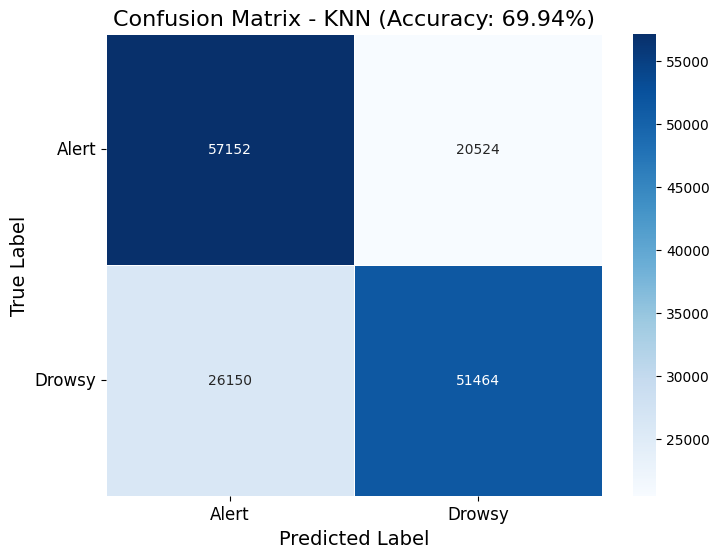

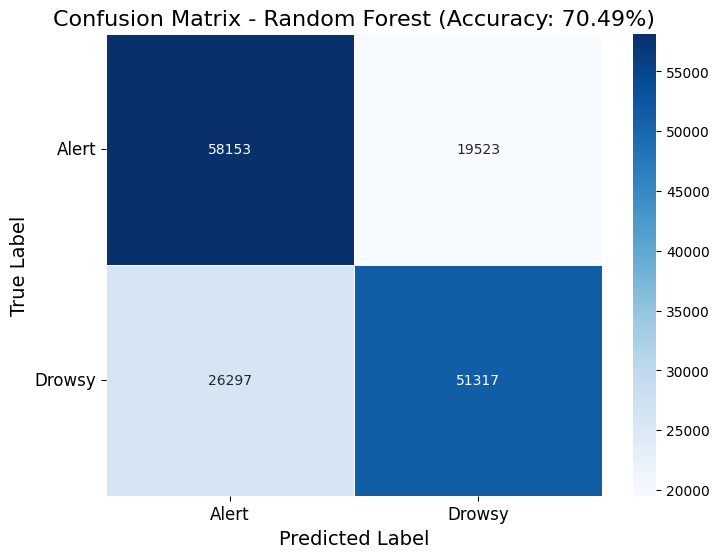

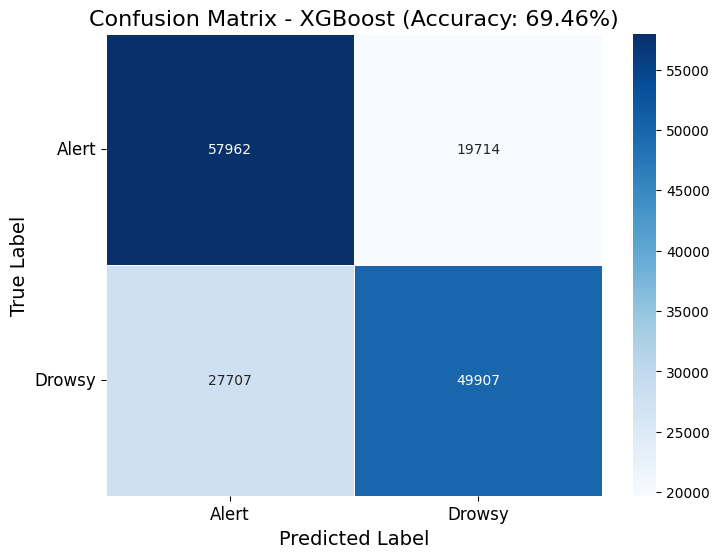

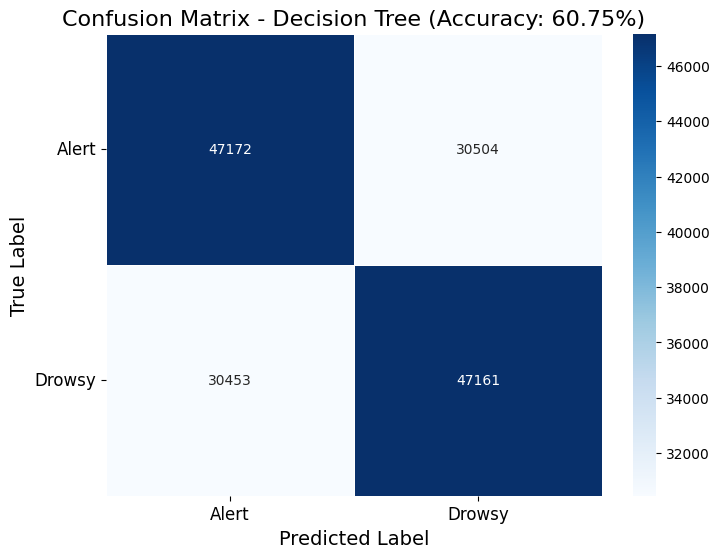

In [46]:
# Define class labels 
class_labels = ["Alert", "Drowsy"]

# Visualization 
for name, matrix in confusion_matrices.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=class_labels, yticklabels=class_labels, linewidths=.5)
    
    accuracy = evaluation_metrics[name]['Accuracy'] * 100 
    plt.title(f'Confusion Matrix - {name} (Accuracy: {accuracy:.2f}%)', fontsize=16)
    
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    
    plt.xticks(rotation=0, fontsize=12)  
    plt.yticks(rotation=0, fontsize=12)  
    
    plt.show()


# Visualization ROC Curve

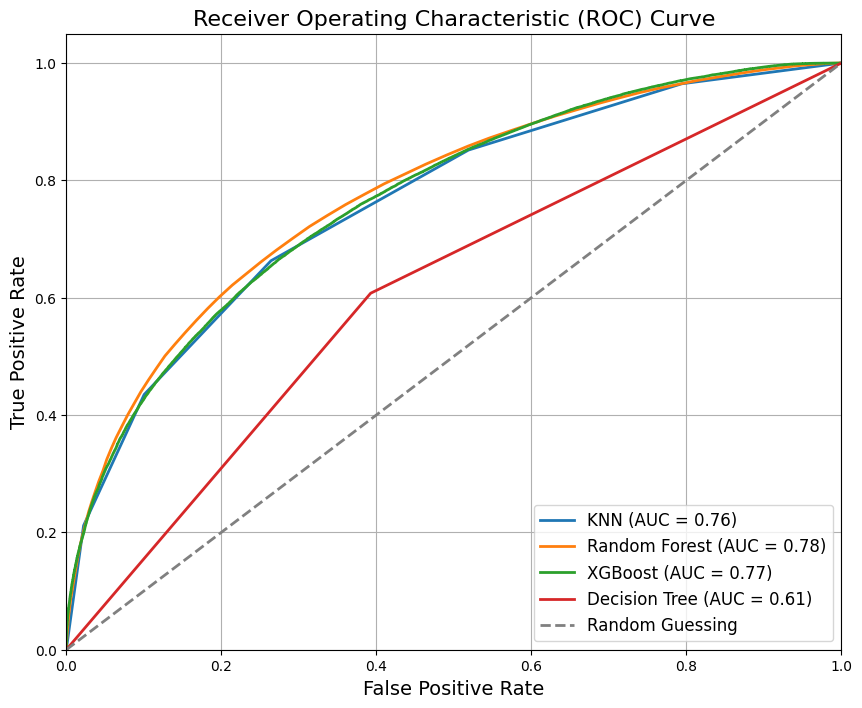

In [47]:
roc_data = {}

# Iterate over classifiers to compute ROC data
for name, classifier in classifiers.items():
    try:
        y_pred_proba = classifier.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)  
        roc_data[name] = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc} 
    except Exception as e:
        print(f"An error occurred with classifier {name}: {e}")

# Plotting ROC Curves 
plt.figure(figsize=(10, 8))
for name, data in roc_data.items():
    plt.plot(data['fpr'], data['tpr'], lw=2, label=f'{name} (AUC = {data["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2, label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.show()